# 0.0. IMPORTS

In [42]:
import pandas                  as pd
import streamlit               as st
import joblib
import sqlite3 
import inflection
import seaborn                 as sns
import numpy                   as np
import matplotlib.pyplot       as plt
import xgboost                 as xgb
import random                  as rd
import pickle
import os

from sklearn.model_selection   import train_test_split, StratifiedKFold
from lightgbm                  import LGBMClassifier
from sklearn.naive_bayes       import GaussianNB
from sklearn.ensemble          import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split, KFold, cross_validate, GridSearchCV
from IPython.display           import Image
from IPython.core.display      import HTML
from boruta                    import BorutaPy
from sklearn.model_selection   import StratifiedShuffleSplit as sss
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import OneHotEncoder
from sklearn.compose           import ColumnTransformer
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.metrics           import f1_score, precision_score, recall_score


from sklearn                   import metrics            as m
from sklearn                   import neighbors          as nh
from sklearn                   import ensemble           as en
from sklearn                   import model_selection    as ms
from scipy                     import stats              as ss

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def ml_error(model_name, precision, recall, f1_score):
    return pd.DataFrame ({'Model Name': model_name,
                          'Precision': precision,
                          'Recall': recall,
                          'F1_score': f1_score}, index = [0])


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [ ]:
df_raw = pd.read_csv('C:/Users/leo_m/repos/Projeto Menzoil/dataset/DF Cientista de dados Jr.csv')
df_raw

In [ ]:
df_raw['Fumante'] = df_raw['Fumante'].map({'yes':1, 'no':0})
df_etl = df_raw.copy()
df_etl

## 0.3. Feature Engineering for ETL

In [ ]:
# classificaçao_corporal
df_etl['Classificaçao_corporal'] = df_etl['IMC'].apply( lambda x: 'thinness' if x < 18.5  else 'normal' if (x >= 18.5) & (x < 24.9) else 'overweight' if (x >= 24.9) & (x < 30) else 'obese' )

# fase_da_vida
df_etl['Fase_da_vida'] = df_etl['Idade'].apply( lambda x: 'kid' if x < 12  else 'teenager' if (x >= 12) & (x < 18) else 'adult' if (x >= 18) & (x < 60) else 'elderly' )

# regiao_geral
df_etl['Regiao_geral'] = df_etl['Regiao'].apply( lambda x: 'south' if (x == 'southwest') or (x == 'southeast')  else 'north')
df_etl

## 0.4. Loading data in SQLITE

In [7]:
#con = sqlite3.connect('C:/Users/leo_m/repos/Projeto Menzoil/sqlite/SQLite_DB.db')
#
#cur = con.cursor()
#
#for index,row in df_etl.iterrows():
#       cur.execute("""INSERT INTO Dados_Fumantes (Idade, Sexo, IMC, Filhos, Fumante, Regiao, Custos, Classificaçao_corporal, Fase_da_vida, Regiao_geral) 
#       VALUES (""" + str(row['Idade']) + "," + '"' + row['Sexo'] + '"' + "," + str(row['IMC']) + "," + str(row['Filhos']) + "," 
#                   + str(row['Fumante']) + "," + '"' + row['Regiao'] + '"' + "," + str(row['Custos']) + ","  + '"' + row['Classificaçao_corporal'] + '"'+ ","  + '"' + row['Fase_da_vida'] + '"' 
#                   + ","  + '"' + row['Regiao_geral'] + '"' + ");")
#    
#
#con.commit()
#
#
#con.close()

## 0.5. Loading data from SQLITE

In [ ]:
con = sqlite3.connect('C:/Users/leo_m/repos/Projeto Menzoil/sqlite/SQLite_DB.db')

cur = con.cursor()
#df = pd.DataFrame(cur.execute("""SELECT Idade,Sexo,IMC, Filhos, Fumante, Regiao, Custos FROM Dados_Fumantes""").fetchall())

df = pd.read_sql_query("""SELECT Idade,Sexo,IMC, Filhos, Fumante, Regiao, Custos, Classificaçao_corporal, Fase_da_vida, Regiao_geral  FROM Dados_Fumantes""", con)

con.close()
df = df.rename(columns={0: 'Idade',1: 'Sexo',2:'IMC',3:'Filhos',4:'Fumante',5:'Regiao',6:'Custos'})

In [ ]:
df

# 1.0. PASSO 01 - DATA DESCRIPTION

In [10]:
df1 = df.copy()

## 1.1. Rename Columns

In [ ]:
df1['Fumante'] = df1['Fumante'].map({1: 'yes', 0:'no'})

cols_old = ['Idade', 'Sexo', 'IMC', 'Filhos', 'Fumante', 'Regiao', 'Custos', 'Classificaçao_corporal', 'Fase_da_vida', 'Regiao_geral']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new
df1

## 1.2. Data Dimensions

In [12]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1338
Number of Cols: 10


## 1.3. Data Types

In [13]:
df1.dtypes

idade                       int64
sexo                       object
imc                       float64
filhos                      int64
fumante                    object
regiao                     object
custos                    float64
classificaçao_corporal     object
fase_da_vida               object
regiao_geral               object
dtype: object

## 1.4. Check NA

In [14]:
df1.isna().sum()

idade                     0
sexo                      0
imc                       0
filhos                    0
fumante                   0
regiao                    0
custos                    0
classificaçao_corporal    0
fase_da_vida              0
regiao_geral              0
dtype: int64

In [15]:
(df1 == '?').sum(axis=0)

idade                     0
sexo                      0
imc                       0
filhos                    0
fumante                   0
regiao                    0
custos                    0
classificaçao_corporal    0
fase_da_vida              0
regiao_geral              0
dtype: int64

## 1.5. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.5.1. Numerical Atributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,idade,18.0000,64.00000,46.00000,39.207025,39.000,14.044709,0.055673,-1.245088
1,imc,15.9600,53.13000,37.17000,30.663397,30.400,6.095908,0.284047,-0.050732
2,filhos,0.0000,5.00000,5.00000,1.094918,1.000,1.205042,0.938380,0.202454
3,custos,1121.8739,63770.42801,62648.55411,13270.422265,9382.033,12105.484976,1.515880,1.606299


### 1.5.2. Categorical Atributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

sexo                      2
fumante                   2
regiao                    4
classificaçao_corporal    4
fase_da_vida              2
regiao_geral              2
dtype: int64

# 2.0. PASSO 02 - EXPLORATORY DATA ANALYSIS

In [19]:
df2 = df1.copy()

## 2.1. Univariate Analysis

### 2.1.1. Response Variable

<AxesSubplot:xlabel='fumante', ylabel='Count'>

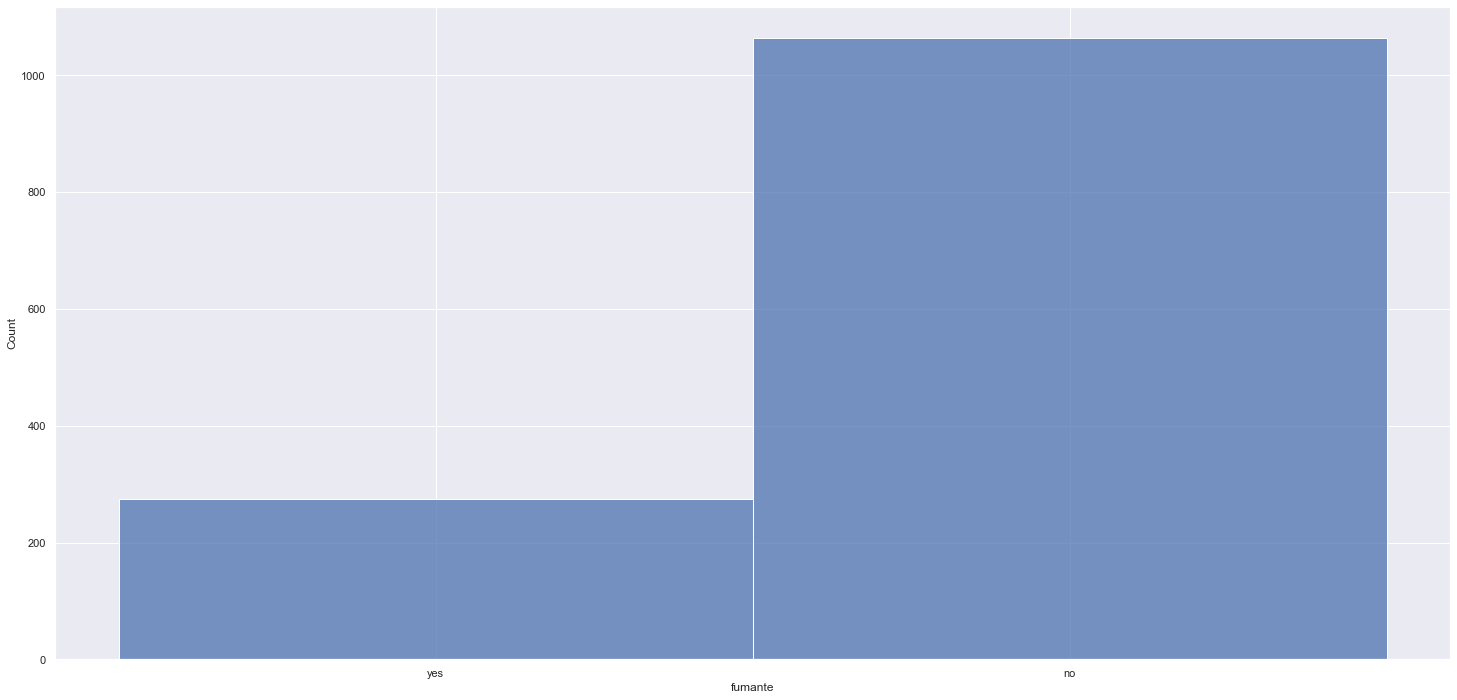

In [20]:
sns.histplot( df2['fumante'], kde=False  )

### 2.1.2. Numerical Variable

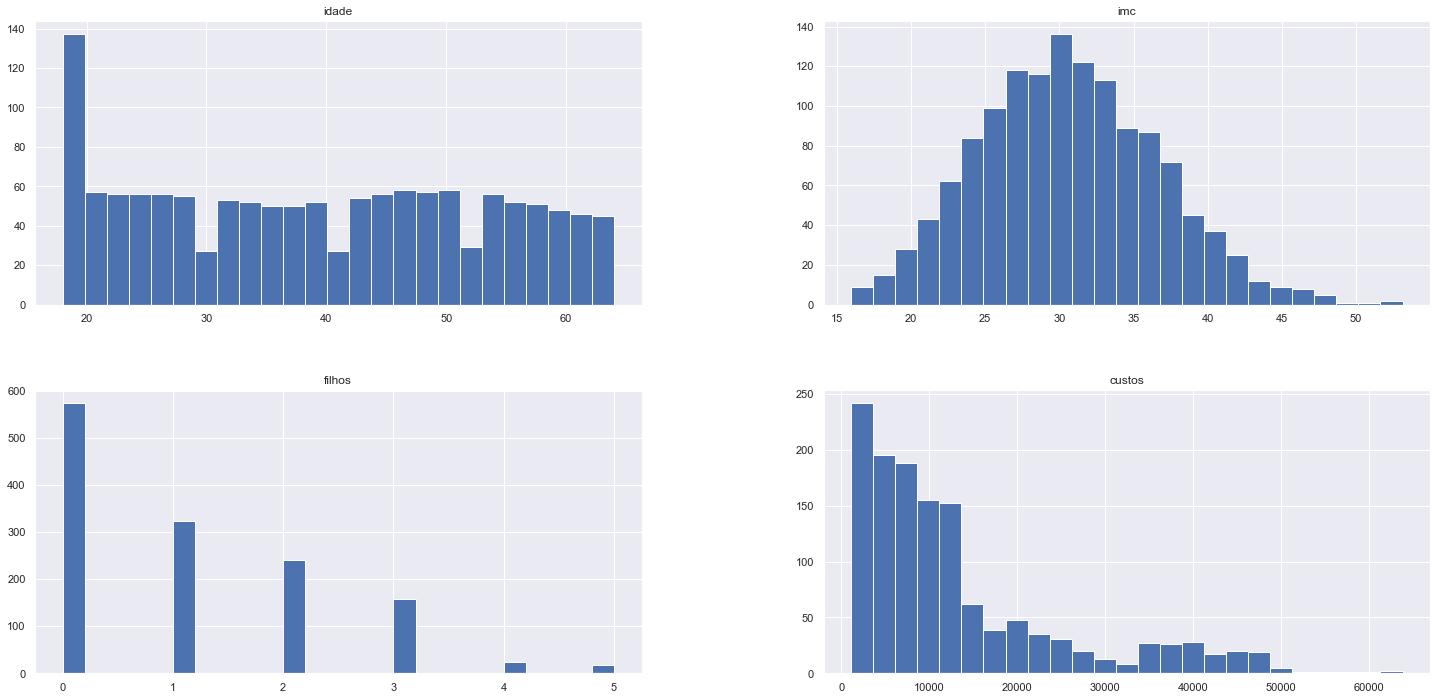

In [21]:
num_attributes.hist(bins = 35);

### 2.1.3. Categorical Variable

In [22]:
df2['sexo'].drop_duplicates()

0    female
1      male
Name: sexo, dtype: object

In [23]:
df2['fumante'].drop_duplicates()

0    yes
1     no
Name: fumante, dtype: object

In [24]:
df2['regiao'].drop_duplicates()

0    southwest
1    southeast
3    northwest
8    northeast
Name: regiao, dtype: object

In [25]:
df2['classificaçao_corporal'].drop_duplicates()

0     overweight
1          obese
3         normal
28      thinness
Name: classificaçao_corporal, dtype: object

In [26]:
df2['fase_da_vida'].drop_duplicates()

0      adult
9    elderly
Name: fase_da_vida, dtype: object

In [27]:
df2['regiao_geral'].drop_duplicates()

0    south
3    north
Name: regiao_geral, dtype: object

C:\Users\leo_m\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\leo_m\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\leo_m\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\leo_m\anaconda3\lib\si

<AxesSubplot:xlabel='regiao_geral', ylabel='count'>

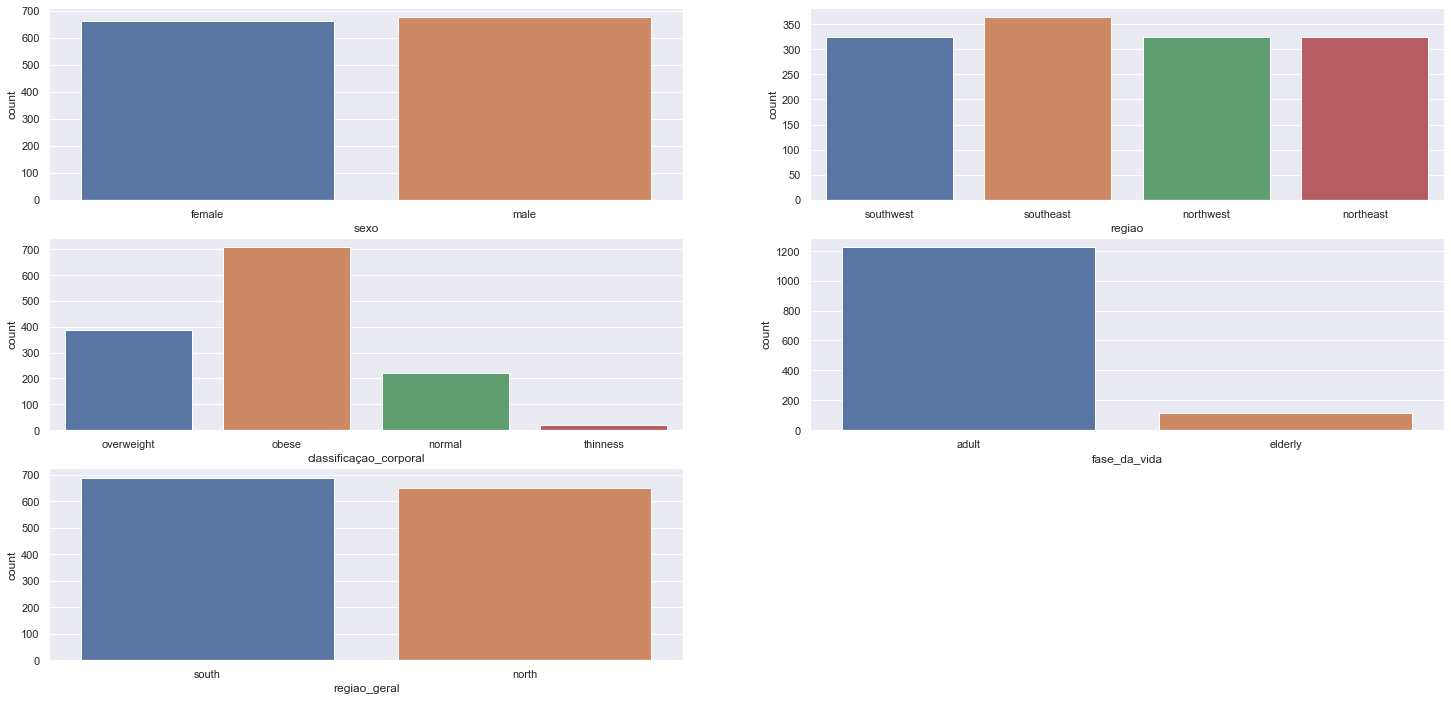

In [28]:
# sexo

plt.subplot(3,2,1)
sns.countplot(df2['sexo'])

# regiao

plt.subplot(3,2,2)
sns.countplot(df2['regiao'])

# classificaçao_corporal

plt.subplot(3,2,3)
sns.countplot(df2['classificaçao_corporal'])

# fase_da_vida

plt.subplot(3,2,4)
sns.countplot(df2['fase_da_vida'])

# regiao_geral

plt.subplot(3,2,5)
sns.countplot(df2['regiao_geral'])


## 2.2 Multivariate analysis

### 2.2.1 Numerical Attributes

<AxesSubplot:>

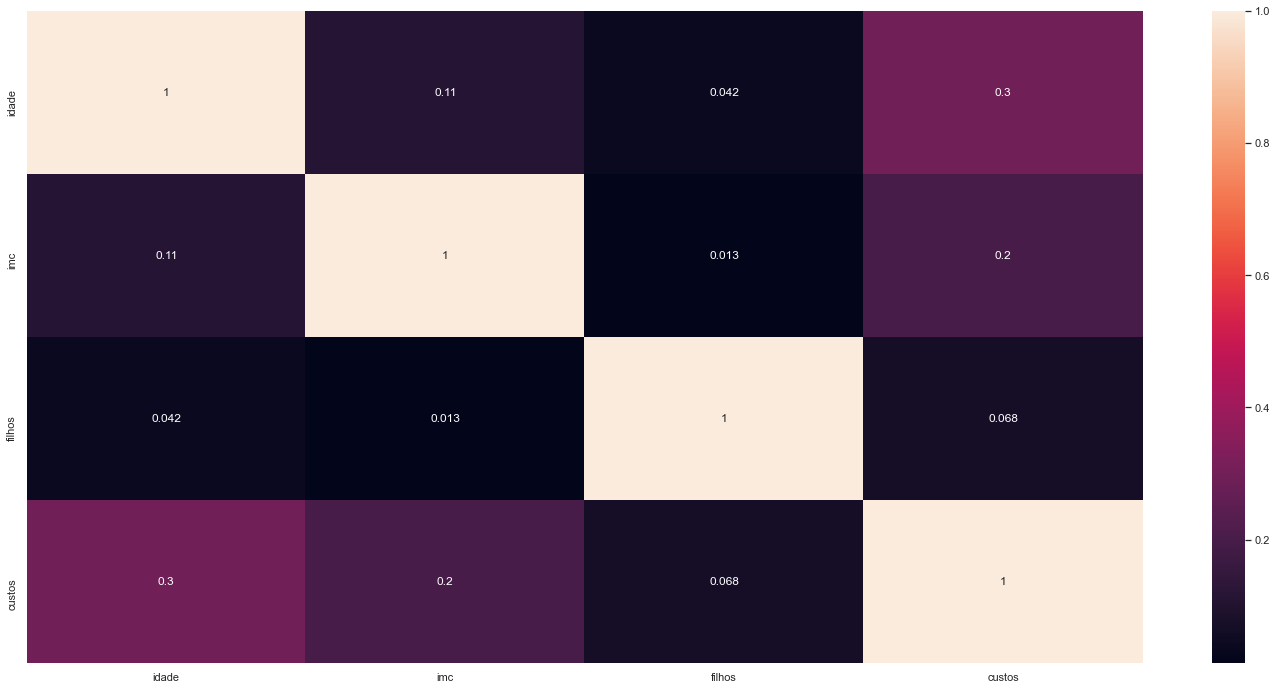

In [29]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 2.3.2 Categorical Attributes

<AxesSubplot:>

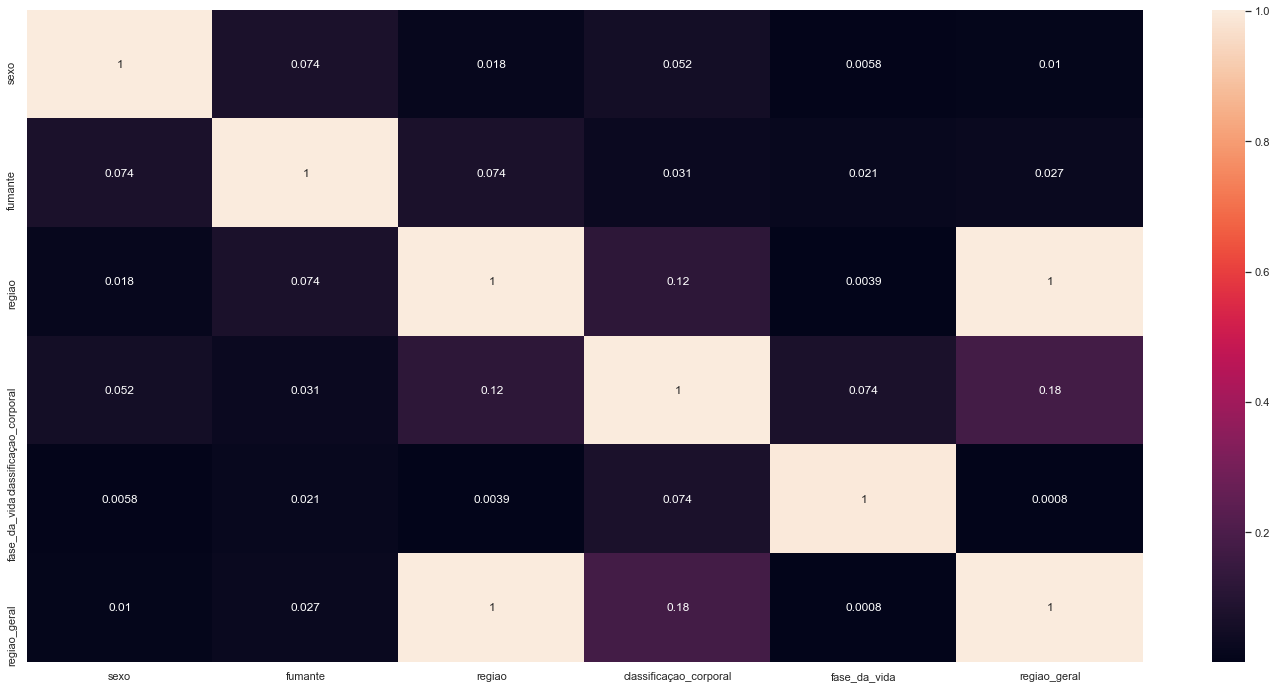

In [30]:
a = cat_attributes

# Calculate cramer V
a1 = cramer_v( a['sexo'], a['sexo'] )
a2 = cramer_v( a['sexo'], a['fumante'] )
a3 = cramer_v( a['sexo'], a['regiao'] )
a4 = cramer_v( a['sexo'], a['classificaçao_corporal'] )
a5 = cramer_v( a['sexo'], a['fase_da_vida'] )
a6 = cramer_v( a['sexo'], a['regiao_geral'] )

a7 = cramer_v( a['fumante'], a['sexo'] )
a8 = cramer_v( a['fumante'], a['fumante'] )
a9 = cramer_v( a['fumante'], a['regiao'] )
a10 = cramer_v( a['fumante'], a['classificaçao_corporal'] )
a11 = cramer_v( a['fumante'], a['fase_da_vida'] )
a12 = cramer_v( a['fumante'], a['regiao_geral'] )

a13 = cramer_v( a['regiao'], a['sexo'] )
a14 = cramer_v( a['regiao'], a['fumante'] )
a15 = cramer_v( a['regiao'], a['regiao'] )
a16 = cramer_v( a['regiao'], a['classificaçao_corporal'] )
a17 = cramer_v( a['regiao'], a['fase_da_vida'] )
a18 = cramer_v( a['regiao'], a['regiao_geral'] )

a19 = cramer_v( a['classificaçao_corporal'], a['sexo'] )
a20 = cramer_v( a['classificaçao_corporal'], a['fumante'] )
a21 = cramer_v( a['classificaçao_corporal'], a['regiao'] )
a22 = cramer_v( a['classificaçao_corporal'], a['classificaçao_corporal'] )
a23 = cramer_v( a['classificaçao_corporal'], a['fase_da_vida'] )
a24 = cramer_v( a['classificaçao_corporal'], a['regiao_geral'] )

a25 = cramer_v( a['fase_da_vida'], a['sexo'] )
a26 = cramer_v( a['fase_da_vida'], a['fumante'] )
a27 = cramer_v( a['fase_da_vida'], a['regiao'] )
a28 = cramer_v( a['fase_da_vida'], a['classificaçao_corporal'] )
a29 = cramer_v( a['fase_da_vida'], a['fase_da_vida'] )
a30 = cramer_v( a['fase_da_vida'], a['regiao_geral'] )

a31 = cramer_v( a['regiao_geral'], a['sexo'] )
a32 = cramer_v( a['regiao_geral'], a['fumante'] )
a33 = cramer_v( a['regiao_geral'], a['regiao'] )
a34 = cramer_v( a['regiao_geral'], a['classificaçao_corporal'] )
a35 = cramer_v( a['regiao_geral'], a['fase_da_vida'] )
a36 = cramer_v( a['regiao_geral'], a['regiao_geral'] )


# Final dataset
d = pd.DataFrame( {'sexo': [a1, a2, a3, a4, a5, a6], 
                   'fumante': [a7, a8, a9, a10, a11, a12], 
                   'regiao': [a13, a14, a15, a16, a17, a18], 
                   'classificaçao_corporal': [a19, a20, a21, a22, a23, a24], 
                   'fase_da_vida': [a25, a26, a27, a28, a29, a30], 
                   'regiao_geral': [a31, a32, a33, a34, a35, a36] 
                  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )


# 3.0. PASSO 03 - MACHINE LEARNING MODULLING

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,idade,sexo,imc,filhos,fumante,regiao,custos,classificaçao_corporal,fase_da_vida,regiao_geral
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,adult,south
1,18,male,33.770,1,no,southeast,1725.55230,obese,adult,south
2,28,male,33.000,3,no,southeast,4449.46200,obese,adult,south
3,33,male,22.705,0,no,northwest,21984.47061,normal,adult,north
4,32,male,28.880,0,no,northwest,3866.85520,overweight,adult,north


## 3.1. Baseline Module

In [34]:
#col = ColumnTransformer([
#    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal'])
#], remainder='passthrough')
#
#pipe = Pipeline([
#    ('col', col),
#    ('model', RandomForestClassifier(n_estimators=100,random_state=4))
#])
#
#X = df5.drop('fumante', axis=1)
#y = df5.fumante.map(lambda x: 1 if x == 'yes' else 0)
#
#results = cross_validate(pipe, X, y, scoring='f1', cv=KFold(n_splits=10, shuffle=True, random_state=0))['test_score']
#results.mean()

In [35]:
col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')

pipe = Pipeline([
    ('col', col),
    ('model', 'passthrough')
])

X = df3.drop('fumante', axis=1)
y = df3.fumante.map(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, shuffle=True, random_state=0)

param_grid = {
    'model': [RandomForestClassifier(random_state=0), LogisticRegression(random_state=0), KNeighborsClassifier(), xgb.XGBClassifier(random_state=0) 
             ]
}

gcv = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=KFold(n_splits=10, shuffle=True, random_state=0))
gcv.fit(X_train, y_train)

C:\Users\leo_m\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leo_m\anaconda3\lib\sit

[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('col',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OneHotEncoder(),
                                                                         ['sexo',
                                                                          'regiao',
                                                                          'classificaçao_corporal',
                                                                          'fase_da_vida',
                                                                          'regiao_geral'])])),
                                       ('model', 'passthrough')]),
             param_grid={'model': [RandomForestClassifier(random_state=0),
                                   Lo

In [36]:
gcv.best_estimator_

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OneHotEncoder(),
                                                  ['sexo', 'regiao',
                                                   'classificaçao_corporal',
                                                   'fase_da_vida',
                                                   'regiao_geral'])])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                            

In [37]:
gcv.best_score_

0.9258967248290556

In [38]:
gcv.best_params_

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)}

In [39]:
col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')


pipe = Pipeline([
    ('col', col),
    ('model', xgb.XGBClassifier(random_state=0))
])
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)
print(f1_score(y_test, y_pred=y_preds))

[00:10:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.902654867256637


C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [40]:
f1_score_xgb = f1_score(y_test, y_pred=y_preds)
precision_xgb = precision_score(y_test, y_preds)
recall_xgb = recall_score(y_test, y_preds)

In [41]:
modelling_result = ml_error('XGBClassifier', precision_xgb, recall_xgb, f1_score_xgb )
modelling_result

,Model Name,Precision,Recall,F1_score
0,XGBClassifier,0.87931,0.927273,0.902655


# 4.0. Passo 04 - HYPERPARAMETER FINE TUNING

In [ ]:
param = {'model__n_estimators':[50, 100, 150, 200, 250],
         'model__eta':[0.01, 0.03, 0.05]
         #'model__gamma':[3, 10, 20],
         #'model__max_depth':[3, 5, 9],
         #'model__subsample':[0.1, 0.5, 0.7],
         #'model__colsample_bytree':[0.3, 0.7, 0.9],
         #'model__min_child_weight':[3, 8, 15],
        }

col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')

pipe = Pipeline([
    ('col', col),
    ('model', xgb.XGBClassifier(use_label_encoder=False,random_state=0) )
])

X = df3.drop('fumante', axis=1)
y = df3.fumante.map(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.20, shuffle=True, random_state=0)

gcv = GridSearchCV(pipe, param_grid=param, scoring='f1', cv=KFold(n_splits=10, shuffle=True, random_state=0))
gcv.fit(X_train, y_train)

In [46]:
gcv.best_params_

{'model__eta': 0.05, 'model__n_estimators': 250}

In [ ]:
param = {'model__n_estimators':[200, 250, 300, 350, 400],
         'model__eta':[0.03, 0.05, 0.07]
         #'model__gamma':[3, 10, 20],
         #'model__max_depth':[3, 5, 9],
         #'model__subsample':[0.1, 0.5, 0.7],
         #'model__colsample_bytree':[0.3, 0.7, 0.9],
         #'model__min_child_weight':[3, 8, 15],
        }

col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')

pipe = Pipeline([
    ('col', col),
    ('model', xgb.XGBClassifier(use_label_encoder=False,random_state=0) )
])

X = df3.drop('fumante', axis=1)
y = df3.fumante.map(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.20, shuffle=True, random_state=0)

gcv = GridSearchCV(pipe, param_grid=param, scoring='f1', cv=KFold(n_splits=10, shuffle=True, random_state=0))
gcv.fit(X_train, y_train)

In [48]:
gcv.best_params_

{'model__eta': 0.05, 'model__n_estimators': 300}

In [49]:
gcv.best_score_

0.9236926431964025

In [ ]:
param = {'model__n_estimators':[280],
         'model__eta':[0.05],
         'model__gamma':[0,10, 20],
         'model__max_depth':[3, 6, 9],
         'model__subsample':[0.5, 0.7, 1]
         #'model__colsample_bytree':[0.3, 0.7, 0.9],
         #'model__min_child_weight':[3, 8, 15],
        }

col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')

pipe = Pipeline([
    ('col', col),
    ('model', xgb.XGBClassifier(use_label_encoder=False,random_state=0) )
])

X = df3.drop('fumante', axis=1)
y = df3.fumante.map(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.20, shuffle=True, random_state=0)

gcv = GridSearchCV(pipe, param_grid=param, scoring='f1', cv=KFold(n_splits=10, shuffle=True, random_state=0))
gcv.fit(X_train, y_train)

In [51]:
gcv.best_params_

{'model__eta': 0.05,
 'model__gamma': 0,
 'model__max_depth': 9,
 'model__n_estimators': 280,
 'model__subsample': 1}

In [52]:
gcv.best_score_

0.9258365935076922

In [ ]:
param = {'model__n_estimators':[280],
         'model__eta':[0.05],
         'model__gamma':[0],
         'model__max_depth':[9],
         'model__subsample':[1],
         'model__colsample_bytree':[0.7, 0.9, 1],
         'model__min_child_weight':[1,3, 8]
        }

col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')

pipe = Pipeline([
    ('col', col),
    ('model', xgb.XGBClassifier(use_label_encoder=False,random_state=0) )
])

X = df3.drop('fumante', axis=1)
y = df3.fumante.map(lambda x: 1 if x == 'yes' else 0)

X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.20, shuffle=True, random_state=0)

gcv = GridSearchCV(pipe, param_grid=param, scoring='f1', cv=KFold(n_splits=10, shuffle=True, random_state=0))
gcv.fit(X_train, y_train)

In [43]:
gcv.best_params_

{'model__colsample_bytree': 1,
 'model__eta': 0.05,
 'model__gamma': 0,
 'model__max_depth': 9,
 'model__min_child_weight': 1,
 'model__n_estimators': 280,
 'model__subsample': 1}

In [44]:
gcv.best_score_

0.9258365935076922

## 4.1. Final Model Tunned

In [45]:
col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')

kwargs = {key.split('model__')[-1]:value for key, value in gcv.best_params_.items()}
pipe = Pipeline([
    ('col', col),
    ('model', xgb.XGBClassifier(random_state=0, **kwargs))
])

pipe.fit(X_train, y_train)
y_preds_ft = pipe.predict(X_test)
print(f1_score(y_test, y_pred=y_preds_ft))

C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:11:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.920353982300885


In [46]:
f1_score_xgb_ft = f1_score(y_test, y_pred=y_preds_ft)
precision_xgb_ft = precision_score(y_test, y_preds_ft)
recall_xgb_ft = recall_score(y_test, y_preds_ft)

In [47]:
modelling_result_ft = ml_error('XGBClassifier', precision_xgb_ft, recall_xgb_ft, f1_score_xgb_ft )
modelling_result_ft

,Model Name,Precision,Recall,F1_score
0,XGBClassifier,0.896552,0.945455,0.920354


## 4.2. Final Model Tunned Oversampling the DataFrame

In [48]:
y_train_ = y_train[y_train == 1].sample(200).append(y_train)
X_train_ = X_train.loc[y_train_.index]

col = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['sexo', 'regiao', 'classificaçao_corporal','fase_da_vida', 'regiao_geral'])
], remainder='passthrough')

kwargs = {key.split('model__')[-1]:value for key, value in gcv.best_params_.items()}
pipe = Pipeline([
    ('col', col),
    ('model', xgb.XGBClassifier(random_state=0, **kwargs))
])

pipe.fit(X_train_, y_train_)
y_preds_ft = pipe.predict(X_test)
print(f1_score(y_test, y_pred=y_preds_ft))

C:\Users\leo_m\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9217391304347826


In [49]:
f1_score_xgb_ft = f1_score(y_test, y_pred=y_preds_ft)
precision_xgb_ft = precision_score(y_test, y_preds_ft)
recall_xgb_ft = recall_score(y_test, y_preds_ft)

In [50]:
modelling_result_ft = ml_error('XGBClassifier', precision_xgb_ft, recall_xgb_ft, f1_score_xgb_ft )
modelling_result_ft

,Model Name,Precision,Recall,F1_score
0,XGBClassifier,0.883333,0.963636,0.921739


# 5. Passo 05 - WEBAPP

In [67]:
# Save Trained Model
#pickle.dump( pipe, open( 'C:/Users/leo_m/Repos/Projeto Menzoil/model/model_menzoil.pkl', 'wb' ) )
joblib.dump( pipe, 'C:/Users/leo_m/Repos/Projeto Menzoil/model/model_menzoil.pkl' )

['C:/Users/leo_m/Repos/Projeto Menzoil/model/model_menzoil.pkl']

## 5.1. Webapp Menzoil Script

In [ ]:
import pandas                  as pd
import streamlit               as st
import joblib
import inflection
import seaborn                 as sns
import numpy                   as np
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import OneHotEncoder
from sklearn.pipeline          import Pipeline

st.write("""
# MENZOIL WEBAPP - Classificação de pessoas fumantes ou não fumantes
""")

st.sidebar.title('Options')
radio_button = st.sidebar.radio('Select:', ['Upload de tabela', 'Input de Dados'])
best_model = joblib.load( 'C:/Users/leo_m/Repos/Projeto Menzoil/model/model_menzoil.pkl' )

if radio_button == 'Upload de tabela':
    try:
        st.write("""
        ### Para classificar as pessoas carregue o arquivo CSV:
        """)
        uploaded_file = st.file_uploader("")
            
        df_raw = pd.read_csv(uploaded_file)
        df_etl = df_raw.copy()

        # classificaçao_corporal
        df_etl['Classificaçao_corporal'] = df_etl['IMC'].apply( lambda x: 'thinness' if x < 18.5  else 'normal' if (x >= 18.5) & (x < 24.9) else 'overweight' if (x >= 24.9) & (x < 30) else 'obese' )

        # fase_da_vida
        df_etl['Fase_da_vida'] = df_etl['Idade'].apply( lambda x: 'kid' if x < 12  else 'teenager' if (x >= 12) & (x < 18) else 'adult' if (x >= 18) & (x < 60) else 'elderly' )

        # regiao_geral
        df_etl['Regiao_geral'] = df_etl['Regiao'].apply( lambda x: 'south' if (x == 'southwest') or (x == 'southeast')  else 'north')

        df1 = df_etl.copy()

        cols_old = ['Idade', 'Sexo', 'IMC', 'Filhos', 'Regiao', 'Custos', 'Classificaçao_corporal', 'Fase_da_vida', 'Regiao_geral']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        df3 = df1.copy()

        y_preds = best_model.predict(df3)
        y_preds = pd.DataFrame(data = y_preds)
        y_preds = y_preds.rename(columns={0: 'Fumante'})
        y_preds = y_preds.Fumante.map(lambda x: 'yes' if x == 1 else 'no')
        y_preds = pd.DataFrame(data = y_preds)

        df_test = pd.concat( [df_raw, y_preds], axis=1)
        st.dataframe(df_test)

    except:
        
        st.stop()


elif radio_button == 'Input de Dados':

    with st.form("unit_form"):
        st.write("""
        ### Preencha com os dados do caso:
        """)
        idade = st.slider("Idade", min_value=1, max_value=100, value=18)
        sexo = st.selectbox('Sexo', ('male', 'female'))
        imc = st.number_input("IMC", value=15.0, step=0.1, format="%.4f")
        filhos = st.slider("Filhos", min_value=0, max_value=10, value=0)
        regiao = st.selectbox('Região', ('southwest', 'southeast', 'northwest', 'northeast'))
        custos = st.number_input("Custos", value=1100.0, step=0.1, format="%.5f")
        

        # Every form must have a submit button.
        submitted = st.form_submit_button("Submit")
        if submitted:
            df = pd.DataFrame([[idade, sexo, imc, filhos, regiao, custos]], columns=['Idade', 'Sexo', 'IMC', 'Filhos', 'Regiao', 'Custos'])
            print(df)
            # classificaçao_corporal
            df['Classificaçao_corporal'] = df['IMC'].apply( lambda x: 'thinness' if x < 18.5  else 'normal' if (x >= 18.5) & (x < 24.9) else 'overweight' if (x >= 24.9) & (x < 30) else 'obese' )

            # fase_da_vida
            df['Fase_da_vida'] = df['Idade'].apply( lambda x: 'kid' if x < 12  else 'teenager' if (x >= 12) & (x < 18) else 'adult' if (x >= 18) & (x < 60) else 'elderly' )

            # regiao_geral
            df['Regiao_geral'] = df['Regiao'].apply( lambda x: 'south' if (x == 'southwest') or (x == 'southeast')  else 'north')


            cols_old = ['Idade', 'Sexo', 'IMC', 'Filhos', 'Regiao', 'Custos', 'Classificaçao_corporal', 'Fase_da_vida', 'Regiao_geral']

            snakecase = lambda x: inflection.underscore( x )

            cols_new = list( map( snakecase, cols_old ) )

            # rename
            df.columns = cols_new
            

            y_preds = best_model.predict(df)
            y_preds = pd.DataFrame(data = y_preds)
            y_preds = y_preds.rename(columns={0: 'Fumante'})
            y_preds = y_preds.Fumante.map(lambda x: 'yes' if x == 1 else 'no')
            y_preds = pd.DataFrame(data = y_preds)

            cols_old = ['idade', 'sexo', 'imc', 'filhos', 'regiao', 'custos', 'classificaçao_corporal', 'fase_da_vida', 'regiao_geral']

            snakecase = lambda x: inflection.humanize( x )

            cols_new = list( map( snakecase, cols_old ) )

            # rename
            df.columns = cols_new
                    

            df_test = pd.concat( [df[['Idade', 'Sexo','Imc','Filhos','Regiao','Custos']], y_preds], axis=1)
            st.dataframe(df_test)
